# Decision Tree

## Setup

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

為了防止一些Sklearn更新的不必要警告:

In [2]:
# import warnings filter
from warnings import simplefilter
#ugnore all future warnings
simplefilter(action='ignore', category=FutureWarning)

創建 images/decision_trees ，並定義通過此筆記本使用的 save_fig() 函數來保存圖：

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "decision_trees"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Read in Data

In [4]:
iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values#只使用這兩個特徵
y_iris = iris.target

## Training and Visualizing a Decision Tree

In [5]:
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

通過使用 export_graphviz()輸出一個名為 iris_tree.dot 的圖形來可視化經過訓練的決策樹：

In [6]:
export_graphviz(
        tree_clf,
        out_file=str(IMAGES_PATH / "iris_tree.dot"),  
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

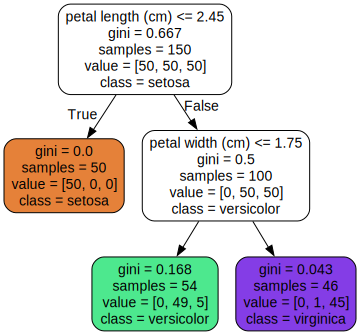

In [7]:
from graphviz import Source

Source.from_file(IMAGES_PATH / "iris_tree.dot") 

### Estimating Class Probabilities

In [11]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [12]:
tree_clf.predict([[5, 1.5]])

array([1])

所以一朵petal length為5且petal width為1.5的花被此決策樹分為第一類，即versicolor類

### Accessing the tree structure

In [32]:
tree = tree_clf.tree_
tree

取得有關這棵樹的資訊

In [33]:
tree.node_count

5

In [34]:
tree.max_depth

2

In [35]:
tree.max_n_classes

3

In [36]:
tree.n_features

2

In [37]:
tree.n_outputs

1

In [38]:
tree.n_leaves

3

All the information about the nodes is stored in NumPy arrays. For example, the impurity of each node:

In [39]:
tree.impurity

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04253308])

The root node is at index 0. The left and right children nodes of node i are tree.children_left[i] and tree.children_right[i]. For example, the children of the root node are:

In [40]:
tree.children_left[0], tree.children_right[0]

(1, 2)

When the left and right nodes are equal, it means this is a leaf node (and the children node ids are arbitrary):

In [41]:
tree.children_left[3], tree.children_right[3]

(-1, -1)

So you can get the leaf node ids like this:

In [42]:
is_leaf = (tree.children_left == tree.children_right)
np.arange(tree.node_count)[is_leaf]

array([1, 3, 4])

Non-leaf nodes are called split nodes. The feature they split is available via the feature array. Values for leaf nodes should be ignored:

In [43]:
tree.feature

array([ 0, -2,  1, -2, -2], dtype=int64)

And the corresponding thresholds are:

In [44]:
tree.threshold

array([ 2.44999999, -2.        ,  1.75      , -2.        , -2.        ])

And the number of observations per class that reached each node is available too:

In [45]:
tree.value

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0.,  1., 45.]]])

In [46]:
tree.n_node_samples

array([150,  50, 100,  54,  46], dtype=int64)

Here's how you can compute the depth of each node:

In [47]:
def compute_depth(tree_clf):
    tree = tree_clf.tree_
    depth = np.zeros(tree.node_count)
    stack = [(0, 0)]
    while stack:
        node, node_depth = stack.pop()
        depth[node] = node_depth
        if tree.children_left[node] != tree.children_right[node]:
            stack.append((tree.children_left[node], node_depth + 1))
            stack.append((tree.children_right[node], node_depth + 1))
    return depth

depth = compute_depth(tree_clf)
depth

array([0., 1., 1., 2., 2.])

Here's how to get the thresholds of all split nodes at depth 1:

In [48]:
tree_clf.tree_.feature[(depth == 1) & (~is_leaf)]

array([1], dtype=int64)

In [49]:
tree_clf.tree_.threshold[(depth == 1) & (~is_leaf)]

array([1.75])

## Regression Tree

決策樹還能夠執行回歸任務。 讓我們使用 Scikit-Learn 的 DecisionTreeRegressor 類構建回歸樹，在 max_depth=2 的嘈雜二次數據集上訓練它：

In [16]:
np.random.seed(42)
X_quad = np.random.rand(200, 1) - 0.5  # a single random input feature
y_quad = X_quad ** 2 + 0.025 * np.random.randn(200, 1)


In [17]:
tree_reg = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg.fit(X_quad, y_quad)

DecisionTreeRegressor(max_depth=2, random_state=42)

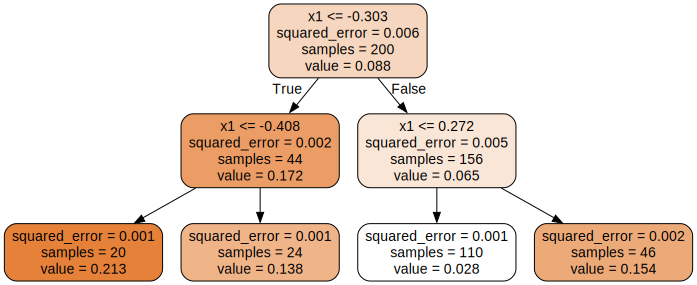

In [22]:
export_graphviz(
    tree_reg,
    out_file=str(IMAGES_PATH / "regression_tree.dot"),
    feature_names=["x1"],
    rounded=True,
    filled=True
)
Source.from_file(IMAGES_PATH / "regression_tree.dot")

## Sensitivity to Axis Orientation

決策樹有一些限制。 首先，決策樹喜歡正交決策邊界（所有拆分都垂直於一個軸），這使得它們對訓練集旋轉很敏感。 例如，下圖顯示了一個簡單的線性可分數據集：在左側，決策樹可以輕鬆地將其拆分，而在右側，數據集旋轉 45° 後，決策邊界看起來不必要地複雜。 雖然兩個決策樹都完美地擬合了訓練集，但右邊的模型很可能無法很好地泛化。 

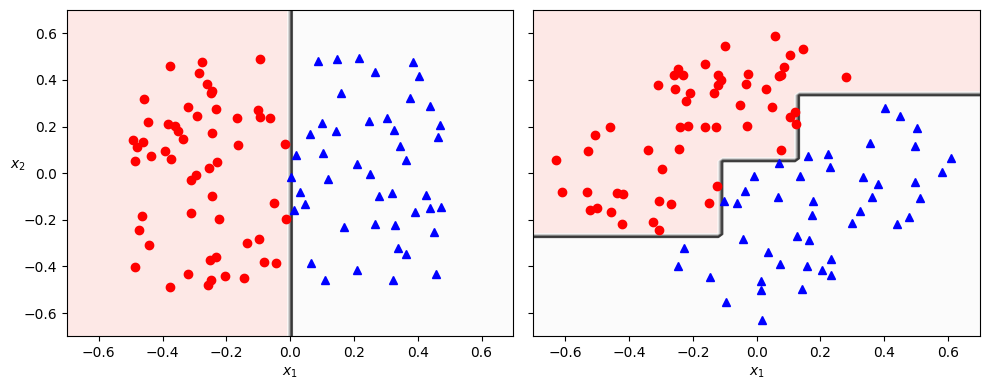

In [24]:
# extra code – this cell generates and saves Figure 6–7
def plot_decision_boundary(clf, X, y, axes, cmap):
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=cmap)
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8)
    colors = {"Wistia": ["#78785c", "#c47b27"], "Pastel1": ["red", "blue"]}
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[cmap][idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)


np.random.seed(6)
X_square = np.random.rand(100, 2) - 0.5
y_square = (X_square[:, 0] > 0).astype(np.int64)

angle = np.pi / 4  # 45 degrees
rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)],
                            [np.sin(angle), np.cos(angle)]])
X_rotated_square = X_square.dot(rotation_matrix)

tree_clf_square = DecisionTreeClassifier(random_state=42)
tree_clf_square.fit(X_square, y_square)
tree_clf_rotated_square = DecisionTreeClassifier(random_state=42)
tree_clf_rotated_square.fit(X_rotated_square, y_square)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf_square, X_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.sca(axes[1])
plot_decision_boundary(tree_clf_rotated_square, X_rotated_square, y_square,
                       axes=[-0.7, 0.7, -0.7, 0.7], cmap="Pastel1")
plt.ylabel("")

save_fig("sensitivity_to_rotation_plot")
plt.show()

限制此問題的一種方法是標準化後使用 PCA，它以減少特徵之間相關性的方式旋轉數據，這通常（並非總是）使樹木更容易。


In [28]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pca_pipeline = make_pipeline(StandardScaler(), PCA())
X_iris_rotated = pca_pipeline.fit_transform(X_iris)
tree_clf_pca = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf_pca.fit(X_iris_rotated, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

<Figure size 800x400 with 0 Axes>

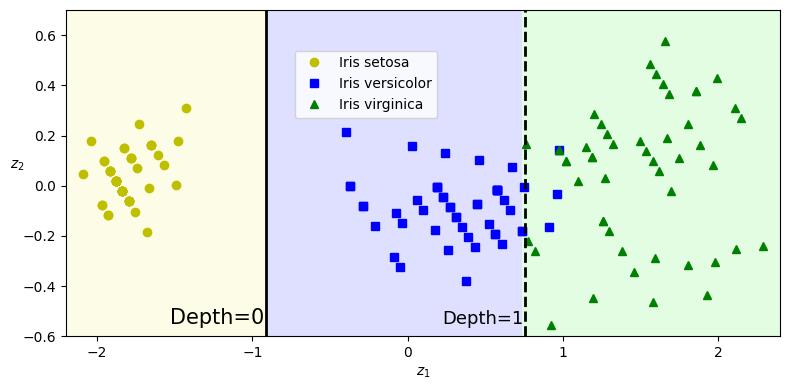

In [31]:
# extra code – this cell generates and saves Figure 6–8
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
plt.figure(figsize=(8, 4))

plt.figure(figsize=(8, 4))

axes = [-2.2, 2.4, -0.6, 0.7]
z0s, z1s = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                       np.linspace(axes[2], axes[3], 100))
X_iris_pca_all = np.c_[z0s.ravel(), z1s.ravel()]
y_pred = tree_clf_pca.predict(X_iris_pca_all).reshape(z0s.shape)

plt.contourf(z0s, z1s, y_pred, alpha=0.3, cmap=custom_cmap)
for idx, (name, style) in enumerate(zip(iris.target_names, ("yo", "bs", "g^"))):
    plt.plot(X_iris_rotated[:, 0][y_iris == idx],
             X_iris_rotated[:, 1][y_iris == idx],
             style, label=f"Iris {name}")

plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
th1, th2 = tree_clf_pca.tree_.threshold[[0, 2]]
plt.plot([th1, th1], axes[2:], "k-", linewidth=2)
plt.plot([th2, th2], axes[2:], "k--", linewidth=2)
plt.text(th1 - 0.01, axes[2] + 0.05, "Depth=0",
         horizontalalignment="right", fontsize=15)
plt.text(th2 - 0.01, axes[2] + 0.05, "Depth=1",
         horizontalalignment="right", fontsize=13)
plt.axis(axes)
plt.legend(loc=(0.32, 0.67))
save_fig("pca_preprocessing_plot")

plt.show()